# Grad-CAM with ResNet50

In [1]:
import os, urllib, tarfile, cv2, skimage, skimage.io, time
import numpy as np
import tensorflow as tf
from tensorflow.python.framework import ops
from tensorflow.python.ops import gen_nn_ops
from tensorflow.contrib.slim.nets import resnet_v1
slim = tf.contrib.slim
from matplotlib import pyplot as plt
from skimage.transform import resize
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'
print ("Packages loaded")

Packages loaded


GuidedReLu operator

In [2]:
@ops.RegisterGradient("GuidedRelu")
def _GuidedReluGrad(op, grad):
    return tf.where(0. < grad, # Use only positive gradient information
                    gen_nn_ops._relu_grad(grad,op.outputs[0]), 
                    tf.zeros(grad.get_shape())
                   )

Get pretrained ResNet

In [3]:
""" Download """
dirpath = "net/"
if not os.path.exists(dirpath): os.makedirs(dirpath)
urlpath = "http://download.tensorflow.org/models/resnet_v1_50_2016_08_28.tar.gz"
zname   = "net/resnet_v1_50_2016_08_28.tar.gz"
if not os.path.exists(zname):
    print ("DOWNLOADING %s..." % (zname))
    urllib.urlretrieve(urlpath, zname)
    print ("DONE")
else: 
    print ("%s ALREADY EXISTS" % (zname))
""" Extract """
fname = "net/resnet_v1_50_2016_08_28"
if not os.path.exists(fname):
    print ("EXTRACTING %s..." % (fname))
    tar = tarfile.open(zname, "r:gz")
    tar.extractall(path=fname)
    tar.close()
    print ("DONE.")
else:
    print ("%s ALREADY EXIST" % (fname))

net/resnet_v1_50_2016_08_28.tar.gz ALREADY EXISTS
net/resnet_v1_50_2016_08_28 ALREADY EXIST


Make graph

In [4]:
eval_graph = tf.Graph()
with eval_graph.as_default():
    with eval_graph.gradient_override_map({'Relu': 'GuidedRelu'}):
    # if 1: 
        x = tf.placeholder(tf.float32, [1, 224, 224, 3])
        y = tf.placeholder(tf.float32, [1, 1000])
        is_train = tf.placeholder(tf.bool)
        with slim.arg_scope(resnet_v1.resnet_arg_scope()): 
            net, end_points = resnet_v1.resnet_v1_50(x,1000,is_training=is_train)
            # print end_points.keys() # print keys
            logit = end_points['resnet_v1_50/logits'] # before softmax
            prob  = end_points['predictions'] # after softmax
            conv  = end_points['resnet_v1_50/block4/unit_2/bottleneck_v1']
            cost  = tf.reduce_sum((logit * y))
            conv_grad = tf.gradients(cost, conv)[0]
            conv_grad_norm = tf.div(conv_grad,
                                   tf.sqrt(tf.reduce_mean(tf.square(conv_grad)))
                                    +tf.constant(1e-10))
            ginit = tf.global_variables_initializer()
            linit = tf.local_variables_initializer()
            """ Restorer """
            ckpt = "net/resnet_v1_50_2016_08_28/resnet_v1_50.ckpt"
            variables_to_restore = slim.get_variables_to_restore(include=["resnet_v1"])
            saver = tf.train.Saver(variables_to_restore)
print ("Graph ready")

Graph ready


Restore

In [5]:
""" Open session """
_config = tf.ConfigProto(); 
_config.gpu_options.allow_growth=True
sess = tf.Session(graph=eval_graph,config=_config)
""" Restore """
sess.run(ginit)
# sess.run(linit)
saver.restore(sess, ckpt)

INFO:tensorflow:Restoring parameters from net/resnet_v1_50_2016_08_28/resnet_v1_50.ckpt


Run

/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


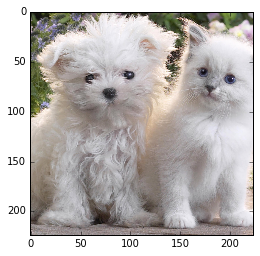

[0][0.442] Maltese dog, Maltese terrier, Maltese
[1][0.216] Shih-Tzu
[2][0.125] affenpinscher, monkey pinscher, monkey dog
[3][0.085] Pomeranian
[4][0.040] toy poodle


In [6]:
""" Load image """
img = skimage.io.imread('./img/dogcat.jpg')
short_edge = min(img.shape[:2])
yy = int((img.shape[0] - short_edge) / 2)
xx = int((img.shape[1] - short_edge) / 2)
crop_img = img[yy: yy + short_edge, xx: xx + short_edge]
img_rgb = skimage.transform.resize(crop_img, (224, 224), preserve_range=True)
img_rgb_rshp = img_rgb.reshape((1, 224, 224, 3))
""" Plot """
plt.imshow(img_rgb/255.)
plt.show()
""" Run graph """
probval = sess.run(prob, feed_dict={x: img_rgb_rshp, is_train: False})
synset = [l.strip() for l in open('./synset.txt').readlines()]
pred = np.argsort(probval.squeeze())[::-1]
top1 = synset[pred[0]]
top5 = [(synset[pred[i]], probval.squeeze()[pred[i]]) for i in range(5)]
names = []
for idx,t in enumerate(top5):
    names.append(t[0][10:])
    print ("[%d][%.3f] %s" % (idx,t[1],t[0][10:]))

Plot

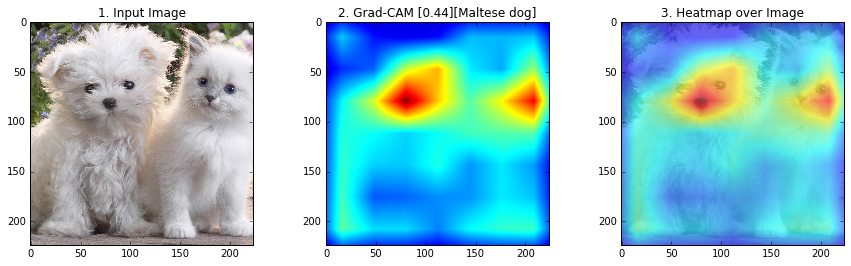

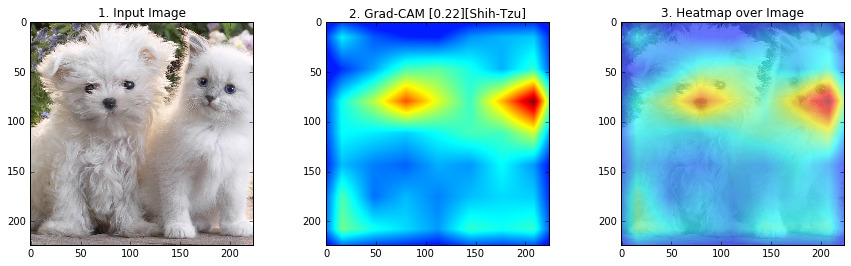

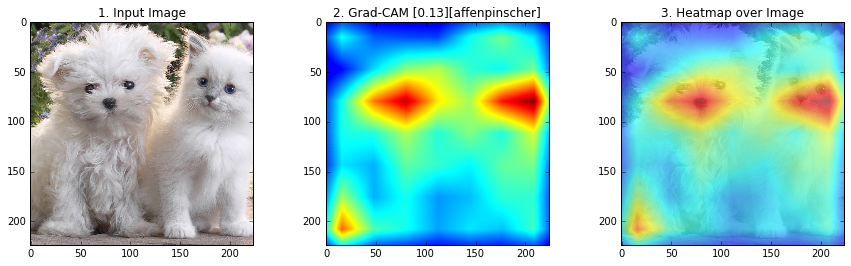

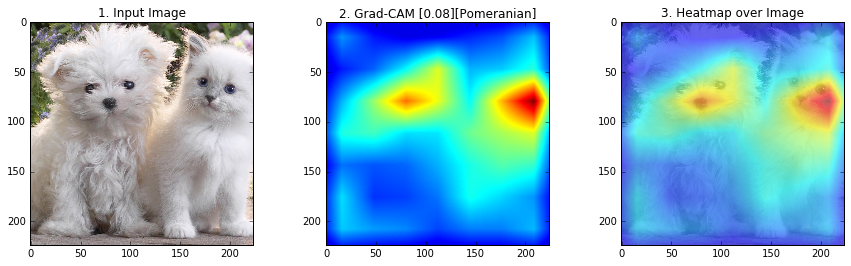

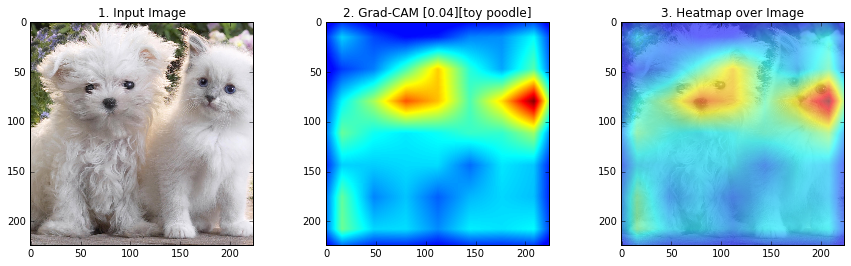

Done.


In [7]:
for idx,pidx in enumerate(pred[:5]):
    target = np.zeros((1,1000))
    target[0,int(pidx)] = 1
    convval,gradval = sess.run([conv,conv_grad_norm],
                              feed_dict={x:img_rgb_rshp,y:target,is_train:True})
    """ Plot """
    output    = convval
    grads_val = gradval
    """ CAM """
    weights   = np.mean(grads_val, axis = (0,1,2)) 			# [512]
    cam       = np.ones(output.shape[1:3], dtype = np.float32)	# [7,7]   
    for i, w in enumerate(weights):
        cam += w * output[0,:,:,i] 
    cam = np.maximum(cam, 0)
    cam = cam / np.max(cam) # scale 0 to 1.0    
    cam_rsz = resize(cam, (224,224),preserve_range=True)
    """ Image """
    img = img_rgb_rshp.squeeze().astype(float)    
    img -= np.min(img)
    img /= img.max()
    """ Heatmap """
    cam_heatmap = cv2.applyColorMap(np.uint8(255*cam_rsz), cv2.COLORMAP_JET)
    cam_heatmap = cv2.cvtColor(cam_heatmap, cv2.COLOR_BGR2RGB)
    """ Plot """
    fig = plt.figure(figsize=(15, 4))    
    ax = fig.add_subplot(131)
    plt.imshow(img)
    ax.set_title('1. Input Image')
    ax = fig.add_subplot(132)
    plt.imshow(cam_heatmap)
    ax.set_title('2. Grad-CAM [%.2f][%s]'%(top5[idx][1],names[idx].split(',')[0]))
    ax = fig.add_subplot(133)
    plt.imshow(img, alpha=.6)
    plt.imshow(cam_heatmap, alpha=.6)
    ax.set_title('3. Heatmap over Image')
    plt.show()
    time.sleep(1)
print ("Done.")